Notebook to create SMILES of search space molecules

SD | FergLab

In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions

import pandas as pd
import numpy as np

import sys
sys.path.append("../Codes/")
import utils_activeLearning_Oliver as ut

In [2]:
DrawingOptions.bondLineWidth=1.8
DrawingOptions.atomLabelFontSize=14
DrawingOptions.includeAtomNumbers=False

Functions to generate molecules using RDKit

In [4]:
# function to mutate an atom
def mutate(rdmol, idx, element):
    
    #print(idx)

    editMol = Chem.EditableMol(rdmol)
    
    #print(Chem.MolToSmiles(editMol.GetMol()))

    editMol.ReplaceAtom(idx, Chem.Atom(element))
    
    #print(Chem.MolToSmiles(editMol.GetMol()))
    
    for nbrs in reversed(rdmol.GetAtomWithIdx(idx).GetNeighbors()):
        
        #print(nbrs.GetSymbol())
        if nbrs.GetSymbol() == 'H' or nbrs.GetSymbol() == 'F' or nbrs.GetSymbol() == 'Cl' or nbrs.GetSymbol() == 'Br':
            
            #print(Chem.MolToSmiles(rdmol))
            editMol.RemoveAtom(nbrs.GetIdx())
            
    #print(Chem.MolToSmiles(editMol.GetMol()))
            
    #editMol.ReplaceAtom(idx, Chem.Atom(element))
    
    mutant = editMol.GetMol()
    Chem.SanitizeMol(mutant)
    mutant = Chem.AddHs(mutant, addCoords=True)
    
    return Chem.MolToSmiles( Chem.RemoveHs(mutant) )

Generate molecules;

Note: molecule_names list variable below is not used (only serves to keep track of molecule names).

In [6]:
molecules = []

molecules_names = []

for i in range(4,15):

    #molecules.append( Chem.MolFromSmiles('C'*i) )
    
    mol = Chem.MolFromSmiles('C'*i)
    
    # append linear hydrocarbons
    molecules.append(Chem.MolToSmiles( mol) )
    
        
    label_i_c_count = Chem.MolToSmiles(mol).count('C')
    molecules_names.append('c' + str(label_i_c_count))
    
    # add explicit hydrogens to SMILES
    mol = Chem.AddHs(mol)
    
    # find index of carbons
    c_index = []
    
    # prepare for editing
    edit = Chem.RWMol(mol)
    
    for atom in edit.GetAtoms():
        if atom.GetAtomicNum() == 6:
            c_index.append(atom.GetIdx())
        
    # debug indices   
    #c_index
        
        
    for at_num in [9, 17, 35]:
        
        c_index_copy = c_index.copy()
        
        for j in range(i):
        
            edit1 = Chem.RWMol(mol)
        
            # replace selected atoms with 
            for atom in edit1.GetAtoms():
            
                if atom.GetAtomicNum() == 6:
            
                #for j in range(i):
                
                    if atom.GetIdx() in c_index_copy:
                    
                        #print(c_index_copy, atom.GetIdx())
                    
                        for nbr in atom.GetNeighbors():
                        
                            if nbr.GetAtomicNum() == 1:
                            
                                nbr.SetAtomicNum(at_num)
                            
            
                            
            #print(c_index_copy)
            #print(j)
            c_index_copy.pop(0)
        
            Chem.SanitizeMol(edit1)
            edit1_mol = Chem.RemoveHs(edit1)
            molecules.append(Chem.MolToSmiles( edit1_mol) )
            
            label_i_c_count = Chem.MolToSmiles(mol).count('c')
            if at_num == 9:
                label_i_halogen_count =  'f' + str(Chem.MolToSmiles(mol).count('F'))
            elif at_num == 17:
                label_i_halogen_count =  'cl' + str(Chem.MolToSmiles(mol).count('Cl') )
            elif at_num == 35:
                label_i_halogen_count =  'br' + str(Chem.MolToSmiles(mol).count('Br') )
                
            molecules_names.append('c' + str(label_i_c_count) + '-' + label_i_halogen_count)
            

primary_molecules = []         
for i in range(len(molecules)):
    
    mol = Chem.MolFromSmiles(molecules[i])
    
    # find head and tail C index; remove duplicates later

    c_index = []
    
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 6:
            c_index.append(atom.GetIdx())
      
    #print(c_index)
            
    # mutate head and tail C with NH2
    
    new_mol1  = mutate(Chem.AddHs(mol), c_index[0], 'N')
    new_mol2  = mutate(Chem.AddHs(mol), c_index[-1], 'N')
    
    primary_molecules.append(new_mol1)
    primary_molecules.append(new_mol2)
        
    # debug indices   
    #c_index
    
secondary_molecules = []
for i in range(len(primary_molecules)):
    
    mol = Chem.AddHs( Chem.MolFromSmiles(primary_molecules[i]) )
    
    # find head and tail C index; remove duplicates later

    h_index = []
    
    for atom in mol.GetAtoms():
        
        if atom.GetSymbol() == 'N':
                        
            for nbr in atom.GetNeighbors():
                                        
                if nbr.GetAtomicNum() == 1:
                                        
                    h_index.append(nbr.GetIdx())
      
    #print(c_index)
    
    #print(h_index)
            
    # mutate head and tail C with NH2
    
    new_mol1  = mutate(mol, h_index[0], 'C')
    
    secondary_molecules.append(new_mol1)
        
    # debug indices   
    #c_index
    
tertiary_molecules = []
for i in range(len(secondary_molecules)):
    
    mol = Chem.AddHs( Chem.MolFromSmiles(secondary_molecules[i]) )
    
    # find head and tail C index; remove duplicates later

    h_index = []
    
    for atom in mol.GetAtoms():
        
        if atom.GetSymbol() == 'N':
                        
            for nbr in atom.GetNeighbors():
                                        
                if nbr.GetAtomicNum() == 1:
                                        
                    h_index.append(nbr.GetIdx())
      
    #print(c_index)
    
    #print(h_index)
            
    # mutate head and tail C with NH2
    
    new_mol1  = mutate(mol, h_index[0], 'C')
    
    tertiary_molecules.append(new_mol1)
        
    # debug indices   
    #c_index
    
    
primary_phos_molecules = []         
for i in range(len(molecules)):
    
    mol = Chem.MolFromSmiles(molecules[i])
    
    # find head and tail C index; remove duplicates later

    c_index = []
    
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 6:
            c_index.append(atom.GetIdx())
      
    #print(c_index)
            
    # mutate head and tail C with NH2
    
    new_mol1  = mutate(Chem.AddHs(mol), c_index[0], 'P')
    new_mol2  = mutate(Chem.AddHs(mol), c_index[-1], 'P')
    
    primary_phos_molecules.append(new_mol1)
    primary_phos_molecules.append(new_mol2)
        
    # debug indices   
    #c_index
    
secondary_phos_molecules = [] 
for i in range(len(primary_phos_molecules)):
    
    mol = Chem.AddHs( Chem.MolFromSmiles(primary_phos_molecules[i]) )
    
    # find head and tail C index; remove duplicates later

    h_index = []
    
    for atom in mol.GetAtoms():
        
        if atom.GetSymbol() == 'P':
                        
            for nbr in atom.GetNeighbors():
                                        
                if nbr.GetAtomicNum() == 1:
                                        
                    h_index.append(nbr.GetIdx())
    
    new_mol1  = mutate(mol, h_index[0], 'C')
    
    secondary_phos_molecules.append(new_mol1)
    

tertiary_phos_molecules = []
for i in range(len(secondary_phos_molecules)):
    
    mol = Chem.AddHs( Chem.MolFromSmiles(secondary_phos_molecules[i]) )
    
    # find head and tail C index; remove duplicates later

    h_index = []
    
    for atom in mol.GetAtoms():
        
        if atom.GetSymbol() == 'P':
                        
            for nbr in atom.GetNeighbors():
                                        
                if nbr.GetAtomicNum() == 1:
                                        
                    h_index.append(nbr.GetIdx())
    
    new_mol1  = mutate(mol, h_index[0], 'C')
    
    tertiary_phos_molecules.append(new_mol1)
    
    
    
primary_charged_molecules = []         
for i in range(len(primary_molecules)):
    
    mol = Chem.MolFromSmiles(primary_molecules[i])

    # prepare for editing
    edit = Chem.RWMol(mol)
    idx1 = edit.AddAtom(Chem.Atom(1))
    
    for atom in edit.GetAtoms():
        
        if atom.GetAtomicNum() == 7:
            idx2 = atom.GetIdx()
        
    bondIdx = edit.AddBond(idx1,idx2, Chem.BondType.SINGLE) 
    edit.GetAtomWithIdx(idx2).SetFormalCharge(1)
    Chem.SanitizeMol(edit)
    edit_mol = Chem.RemoveHs(edit)
    
    primary_charged_molecules.append(Chem.MolToSmiles(edit_mol))
    
    
secondary_charged_molecules = []         
for i in range(len(primary_molecules)):
    
    mol = Chem.MolFromSmiles(primary_molecules[i])

    # prepare for editing
    edit = Chem.RWMol(mol)
    idx1 = edit.AddAtom(Chem.Atom(6))
    
    for atom in edit.GetAtoms():
        
        if atom.GetAtomicNum() == 7:
            idx2 = atom.GetIdx()
        
    bondIdx = edit.AddBond(idx1,idx2, Chem.BondType.SINGLE) 
    edit.GetAtomWithIdx(idx2).SetFormalCharge(1)
    Chem.SanitizeMol(edit)
    edit_mol = Chem.RemoveHs(edit)
    
    secondary_charged_molecules.append(Chem.MolToSmiles(edit_mol))
    
tertiary_charged_molecules = []         
for i in range(len(secondary_molecules)):
    
    mol = Chem.MolFromSmiles(secondary_molecules[i])

    # prepare for editing
    edit = Chem.RWMol(mol)
    idx1 = edit.AddAtom(Chem.Atom(6))
    
    for atom in edit.GetAtoms():
        
        if atom.GetAtomicNum() == 7:
            idx2 = atom.GetIdx()
        
    bondIdx = edit.AddBond(idx1,idx2, Chem.BondType.SINGLE) 
    edit.GetAtomWithIdx(idx2).SetFormalCharge(1)
    Chem.SanitizeMol(edit)
    edit_mol = Chem.RemoveHs(edit)
    
    tertiary_charged_molecules.append(Chem.MolToSmiles(edit_mol))
 
    
primary_phos_charged_molecules = []         
for i in range(len(primary_phos_molecules)):
    
    mol = Chem.MolFromSmiles(primary_phos_molecules[i])

    # prepare for editing
    edit = Chem.RWMol(mol)
    idx1 = edit.AddAtom(Chem.Atom(1))
    
    for atom in edit.GetAtoms():
        
        if atom.GetAtomicNum() == 15:
            idx2 = atom.GetIdx()
        
    bondIdx = edit.AddBond(idx1,idx2, Chem.BondType.SINGLE) 
    edit.GetAtomWithIdx(idx2).SetFormalCharge(1)
    Chem.SanitizeMol(edit)
    edit_mol = Chem.RemoveHs(edit)
    
    primary_phos_charged_molecules.append(Chem.MolToSmiles(edit_mol))
    
    
secondary_phos_charged_molecules = []         
for i in range(len(primary_phos_molecules)):
    
    mol = Chem.MolFromSmiles(primary_phos_molecules[i])

    # prepare for editing
    edit = Chem.RWMol(mol)
    idx1 = edit.AddAtom(Chem.Atom(6))
    
    for atom in edit.GetAtoms():
        
        if atom.GetAtomicNum() == 15:
            idx2 = atom.GetIdx()
        
    bondIdx = edit.AddBond(idx1,idx2, Chem.BondType.SINGLE) 
    edit.GetAtomWithIdx(idx2).SetFormalCharge(1)
    Chem.SanitizeMol(edit)
    edit_mol = Chem.RemoveHs(edit)
    
    secondary_phos_charged_molecules.append(Chem.MolToSmiles(edit_mol))
    
tertiary_phos_charged_molecules = []         
for i in range(len(secondary_phos_molecules)):
    
    mol = Chem.MolFromSmiles(secondary_phos_molecules[i])

    # prepare for editing
    edit = Chem.RWMol(mol)
    idx1 = edit.AddAtom(Chem.Atom(6))
    
    for atom in edit.GetAtoms():
        
        if atom.GetAtomicNum() == 15:
            idx2 = atom.GetIdx()
        
    bondIdx = edit.AddBond(idx1,idx2, Chem.BondType.SINGLE) 
    edit.GetAtomWithIdx(idx2).SetFormalCharge(1)
    Chem.SanitizeMol(edit)
    edit_mol = Chem.RemoveHs(edit)
    
    tertiary_phos_charged_molecules.append(Chem.MolToSmiles(edit_mol))
    
    
quaternary_charged_molecules = []         
for i in range(len(tertiary_charged_molecules)):
    
    mol = Chem.MolFromSmiles(tertiary_charged_molecules[i])

    # prepare for editing
    edit = Chem.RWMol(Chem.AddHs(mol))
    idx1 = edit.AddAtom(Chem.Atom(6))
    
    for atom in edit.GetAtoms():
    
        if atom.GetAtomicNum() == 7:
        
            idx2 = atom.GetIdx()
        
            for nbr in atom.GetNeighbors():
            
                if nbr.GetAtomicNum() == 1:
                    idx3 = nbr.GetIdx()
        
    bondIdx = edit.AddBond(idx1,idx2, Chem.BondType.SINGLE)
    edit.RemoveAtom(idx3) 
    edit.GetAtomWithIdx(idx2).SetFormalCharge(1)
    Chem.SanitizeMol(edit)
    edit_mol = Chem.RemoveHs(edit)

    quaternary_charged_molecules.append(Chem.MolToSmiles(edit_mol))
    
    
quaternary_phos_charged_molecules = []         
for i in range(len(tertiary_phos_charged_molecules)):
    
    mol = Chem.MolFromSmiles(tertiary_phos_charged_molecules[i])

    # prepare for editing
    edit = Chem.RWMol(Chem.AddHs(mol))
    idx1 = edit.AddAtom(Chem.Atom(6))
    
    for atom in edit.GetAtoms():
    
        if atom.GetAtomicNum() == 15:
        
            idx2 = atom.GetIdx()
        
            for nbr in atom.GetNeighbors():
            
                if nbr.GetAtomicNum() == 1:
                    idx3 = nbr.GetIdx()
        
    bondIdx = edit.AddBond(idx1,idx2, Chem.BondType.SINGLE)
    edit.RemoveAtom(idx3) 
    edit.GetAtomWithIdx(idx2).SetFormalCharge(1)
    Chem.SanitizeMol(edit)
    edit_mol = Chem.RemoveHs(edit)

    quaternary_phos_charged_molecules.append(Chem.MolToSmiles(edit_mol))
    
    
#molecules = list(set(molecules))
#molecules_names = list(set(molecules_names))
#
#primary_molecules = list(set(primary_molecules))
#secondary_molecules = list(set(secondary_molecules))
#tertiary_molecules = list(set(tertiary_molecules))
#
#primary_phos_molecules = list(set(primary_phos_molecules))
#secondary_phos_molecules = list(set(secondary_phos_molecules))
#tertiary_phos_molecules = list(set(tertiary_phos_molecules))
#
#primary_charged_molecules = list(set(primary_charged_molecules))
#secondary_charged_molecules = list(set(secondary_charged_molecules))
#tertiary_charged_molecules = list(set(tertiary_charged_molecules))
#
#primary_phos_charged_molecules = list(set(primary_phos_charged_molecules))
#secondary_phos_charged_molecules = list(set(secondary_phos_charged_molecules))
#tertiary_phos_charged_molecules = list(set(tertiary_phos_charged_molecules))
#
#quaternary_charged_molecules = list(set(quaternary_charged_molecules))
#quaternary_phos_charged_molecules = list(set(quaternary_phos_charged_molecules))
#
#
#all_molecules = molecules + primary_molecules + secondary_molecules + tertiary_molecules
#all_molecules = all_molecules + primary_phos_molecules + secondary_phos_molecules + tertiary_phos_molecules
##all_molecules += primary_charged_molecules + secondary_charged_molecules + tertiary_charged_molecules
##all_molecules += primary_phos_charged_molecules + secondary_phos_charged_molecules + tertiary_phos_charged_molecules
#
#all_molecules += quaternary_charged_molecules
##all_molecules += quaternary_phos_charged_molecules
#
#
#all_molecules_df = pd.DataFrame(all_molecules, columns =['smiles']) 
#

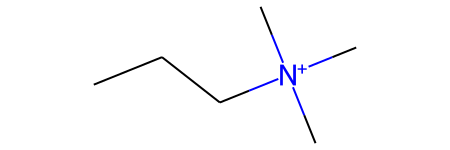

In [25]:
# plot
Chem.MolFromSmiles( quaternary_charged_molecules[0] )

For naming molecules using SMILES

In [ ]:
probeNames = []
for i in range(selected_probes_df.shape[0]):
    
    smiles = selected_probes_df.smiles.values[i]
    
    label_i_c_count = smiles.count('C')
    
    label_i_f_count = smiles.count('F')
    
    label_i_cl_count = smiles.count('Cl')
    
    label_i_br_count = smiles.count('Br')
    
    if label_i_cl_count != 0:
        label_i_c_count -= label_i_cl_count
        
    fstring = '-f'
    if label_i_cl_count > 0:
        label_i_f_count = label_i_cl_count
        fstring = '-cl'
        
    if label_i_br_count > 0:
        label_i_f_count = label_i_br_count
        fstring = '-br'
        
        
     
    countP = -1
    if smiles.count('P') > 0:
        
        countP = smiles.count('P')
        smiles = smiles.replace('P', 'N')
        
    
    rdkProbe = Chem.MolFromSmiles(smiles, sanitize=True)
    
    label_i_head_group_h_count = -1
    label_i_head_group_c_count = -1
    
    if fr_NH2(rdkProbe) == 1 and fr_quatN(rdkProbe) == 0 :
        label_i_head_group_h_count = 2
        label_i_head_group_c_count = 0
        #print(probes[i], "primary amine")
    elif fr_NH1(rdkProbe) == 1 and fr_quatN(rdkProbe) == 0:
        label_i_head_group_h_count = 1
        label_i_head_group_c_count = 1
        #print(probes[i], "secondary amine")
    elif fr_NH0(rdkProbe) == 1 and fr_quatN(rdkProbe) == 0:
        label_i_head_group_h_count = 0
        label_i_head_group_c_count = 2
        #label_i_head_group = "0"
        #print(probes[i], "tertiary amine")
    elif fr_NH0(rdkProbe) == 1 and fr_quatN(rdkProbe) == 1:
        label_i_head_group_h_count = 0
        label_i_head_group_c_count = 3
        #label_i_head_group = ""
        #print(probes[i], "quaternary amine")
    elif fr_NH2(rdkProbe) == 1 and fr_quatN(rdkProbe) == 1 :
        label_i_head_group_h_count = 2
        label_i_head_group_c_count = 1
        #print(probes[i], "secondary amine cation") 
    elif fr_NH1(rdkProbe) == 1 and fr_quatN(rdkProbe) == 1:
        label_i_head_group_h_count = 1
        label_i_head_group_c_count = 2
        #print(probes[i], "tertiary amine cation")
    elif fr_NH0(rdkProbe) == 0 and fr_quatN(rdkProbe) == 1:
        label_i_head_group_h_count = 3
        label_i_head_group_c_count = 0

    if label_i_head_group_c_count > 0:
        label_i_c_count = label_i_c_count - label_i_head_group_c_count
    
    if countP == -1:
    
        if label_i_head_group_h_count == -1 and label_i_head_group_c_count == -1:
            label_i = 'c' + str(label_i_c_count) + fstring + str(label_i_f_count)
        elif label_i_head_group_h_count == 0:
            label_i = 'c' + str(label_i_c_count) + fstring + str(label_i_f_count) + '-n' + '(ch3)' + str(label_i_head_group_c_count)
        elif label_i_head_group_c_count == 0:
            label_i = 'c' + str(label_i_c_count) + fstring + str(label_i_f_count) + '-nh' + str(label_i_head_group_h_count)
        elif label_i_head_group_h_count > 0 and label_i_head_group_c_count > 0:
            label_i = 'c' + str(label_i_c_count) + fstring + str(label_i_f_count) + '-nh' + str(label_i_head_group_h_count) + '(ch3)' + str(label_i_head_group_c_count)
    else:
        
        if label_i_head_group_h_count == -1 and label_i_head_group_c_count == -1:
            label_i = 'c' + str(label_i_c_count) + fstring + str(label_i_f_count)
        elif label_i_head_group_h_count == 0:
            label_i = 'c' + str(label_i_c_count) + fstring + str(label_i_f_count) + '-p' + '(ch3)' + str(label_i_head_group_c_count)
        elif label_i_head_group_c_count == 0:
            label_i = 'c' + str(label_i_c_count) + fstring + str(label_i_f_count) + '-ph' + str(label_i_head_group_h_count)
        elif label_i_head_group_h_count > 0 and label_i_head_group_c_count > 0:
            label_i = 'c' + str(label_i_c_count) + fstring + str(label_i_f_count) + '-ph' + str(label_i_head_group_h_count) + '(ch3)' + str(label_i_head_group_c_count)
        
    
    probeName = label_i
    
    probeNames.append(probeName)
    print(probeName)

In [3]:
#all_molecules = quaternary_phos_charged_molecules
#all_molecules_df = pd.DataFrame(all_molecules, columns =['smiles'])

# DO NOT EXIST IN TRAINING SET (SO NO LATENT REPRESENTATION; THEREFORE EXCLUDING THESE COMBINATIONS)
# primary_charged_molecules + secondary_charged_molecules + tertiary_charged_molecules
# primary_phos_charged_molecules + secondary_phos_charged_molecules + tertiary_phos_charged_molecules
# quaternary_phos_charged_molecules

In [62]:
8*506+308

4356

In [80]:
print(len(molecules))
print(len(primary_molecules))
print(len(secondary_molecules))
print(len(tertiary_molecules))
print(len(all_molecules))
print(len(primary_phos_molecules))
print(len(primary_charged_molecules))
print(len(secondary_charged_molecules))
print(len(tertiary_charged_molecules))
print(len(primary_phos_charged_molecules))
print(len(secondary_phos_charged_molecules))
print(len(tertiary_phos_charged_molecules))
print(len(quaternary_charged_molecules))
print(len(quaternary_phos_charged_molecules))
print(len(all_molecules))

308
506
506
506
3850
506
506
506
506
506
506
506
506
506
3850


Filter molecules based on alphabets used in trianing VAE --- requires utils codes

In [81]:
# filter probes using alphabet list extracted from the training set molecules
alphabet_list = pd.read_csv('codes/data/alphabet-list.csv')['alphabets'].tolist()
print(alphabet_list)

alpha_exists = ut.check_molecules_alphabets_exists(all_molecules_df)

#print("\n probes alphabet list")
#print(alpha_exists)

all_molecules_df['smilesValid'] = np.array(alpha_exists)

all_molecules_dfValid = all_molecules_df[ (all_molecules_df.smilesValid == True) ]

print(all_molecules_dfValid.shape)

['[epsilon]', '[C]', '[=C]', '[C@Hexpl]', '[N]', '[Ring1]', '[Branch1_1]', '[C@@Hexpl]', '[Branch1_3]', '[=O]', '[O]', '[Branch2_3]', '[Branch2_1]', '[=N]', '[c]', '[F]', '[Ring2]', '[Branch1_2]', '[o]', '[n]', '[S]', '[Branch2_2]', '[#N]', '[#C]', '[=S]', '[s]', '[-c]', '[Cl]', '[=c]', '[/C]', '[/c]', '[Br]', '[-n]', '[nHexpl]', '[=N+expl]', '[O-expl]', '[N+expl]', '[C@expl]', '[C@@expl]', '[/N]', '[\\S]', '[\\c]', '[.]', '[n+expl]', '[/O]', '[Expl-Ring1]', '[\\C]', '[P]', '[/S]', '[\\N]', '[\\O]', '[I]', '[Siexpl]', '[S@@expl]', '[S@expl]']
(3850, 2)


(4356, 2)
(506, 2)


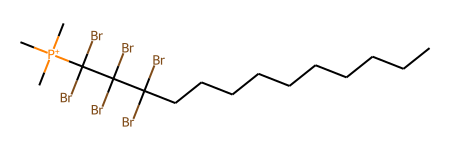

In [69]:
all_molecules_dfInvalid = all_molecules_df[ (all_molecules_df.smilesValid == False) ]
print( all_molecules_df.shape  )
print( all_molecules_dfInvalid.shape )
Chem.MolFromSmiles( all_molecules_dfInvalid.smiles.values[20] )

Save to file

In [82]:
all_molecules_dfValid.to_csv("../Data/VAE_data/SMILES_linearProbes_All.csv", columns=['smiles'], index=False)
all_molecules_dfValid

,smiles,smilesValid
0,CCCCCCCCCCCC(Br)(Br)Br,True
1,CC(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)Br,True
2,CCCCCCCC(Br)(Br)Br,True
3,CCCCCCC(F)(F)C(F)(F)C(F)(F)F,True
4,CCCCC(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(...,True
...,...,...
3845,CCCCCCCCCC(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)[...,True
3846,C[N+](C)(C)CCC(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(...,True
3847,CCCCCCCC(F)(F)[N+](C)(C)C,True
3848,C[N+](C)(C)CCCC(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)...,True


In [83]:
all_molecules_dfValid = pd.read_csv("../Data/VAE_data/SMILES_linearProbes_All.csv")

all_molecules_dfValid

,smiles
0,CCCCCCCCCCCC(Br)(Br)Br
1,CC(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)(Br)Br
2,CCCCCCCC(Br)(Br)Br
3,CCCCCCC(F)(F)C(F)(F)C(F)(F)F
4,CCCCC(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(...
...,...
3845,CCCCCCCCCC(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)[...
3846,C[N+](C)(C)CCC(Cl)(Cl)C(Cl)(Cl)C(Cl)(Cl)C(Cl)(...
3847,CCCCCCCC(F)(F)[N+](C)(C)C
3848,C[N+](C)(C)CCCC(Br)(Br)C(Br)(Br)C(Br)(Br)C(Br)...


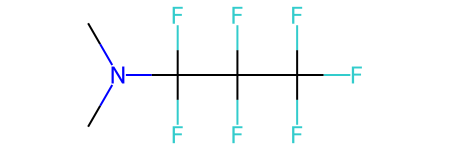

In [535]:
Chem.MolFromSmiles( tertiary_molecules[2] )